In [2]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, QiskitError
#from qiskit import execute, BasicAer
import qiskit.ignis.verification.randomized_benchmarking as rb
#import qiskit.test.benchmarks.randomized_benchmarking as br
import pyzx
from pyzx.circuit.qasmparser import QASMParser
from pyzx.circuit.qiskitqasmparser import QiskitQASMParser

In [3]:
#qc = rb.randomized_benchmarking_seq()
qc = rb.randomized_benchmarking_seq(nseeds=1, length_vector=None,
                                rb_pattern=[[0,1]],
                                length_multiplier=1, seed_offset=0,
                                align_cliffs=False,
                                interleaved_gates=None,
                                is_purity=False)
qc = qc[0][0][0]

In [4]:
# setting up the backend
# print(BasicAer.backends())

# running the job
# job_sim = execute(qc, BasicAer.get_backend('qasm_simulator'))
# sim_result = job_sim.result()

In [5]:
# print("\nPrint all gates:")
# [print(dat) for dat in qc.data]

In [6]:
qasm = qc.qasm()
### if you want to remove all barriers
## qasm = '\n'.join(['' if line.startswith("barrier") else line for line in qasm.splitlines()])

qc = qc.from_qasm_str(qasm)

print("\nPrint QASM:")
print(qasm)


Print QASM:
OPENQASM 2.0;
include "qelib1.inc";
qreg qr[2];
creg cr[2];
h qr[0];
s qr[0];
cx qr[0],qr[1];
cx qr[1],qr[0];
h qr[1];
s qr[1];
z qr[0];
x qr[1];
barrier qr[0],qr[1];
x qr[1];
z qr[0];
sdg qr[1];
h qr[1];
cx qr[1],qr[0];
cx qr[0],qr[1];
sdg qr[0];
h qr[0];
measure qr[0] -> cr[0];
measure qr[1] -> cr[1];



In [7]:
# Draw the circuit
print(qc)

         ┌───┐┌───┐     ┌───┐┌───┐           ░ ┌───┐            ┌───┐     »
qr_0: |0>┤ H ├┤ S ├──■──┤ X ├┤ Z ├───────────░─┤ Z ├────────────┤ X ├──■──»
         └───┘└───┘┌─┴─┐└─┬─┘├───┤┌───┐┌───┐ ░ ├───┤┌─────┐┌───┐└─┬─┘┌─┴─┐»
qr_1: |0>──────────┤ X ├──■──┤ H ├┤ S ├┤ X ├─░─┤ X ├┤ Sdg ├┤ H ├──■──┤ X ├»
                   └───┘     └───┘└───┘└───┘ ░ └───┘└─────┘└───┘     └───┘»
 cr_0: 0 ═════════════════════════════════════════════════════════════════»
                                                                          »
 cr_1: 0 ═════════════════════════════════════════════════════════════════»
                                                                          »
«      ┌─────┐┌───┐┌─┐
«qr_0: ┤ Sdg ├┤ H ├┤M├
«      └─┬─┬─┘└───┘└╥┘
«qr_1: ──┤M├────────╫─
«        └╥┘        ║ 
«cr_0: ═══╬═════════╩═
«         ║           
«cr_1: ═══╩═══════════
«                     


In [8]:
p = QiskitQASMParser()
circ_list, whichpyzx = p.qiskitparse(qasm)
print(circ_list)
print(whichpyzx)
print(p.registers)

['qreg qr[2];', 'creg cr[2];', Circuit(2 qubits, 8 gates), 'barrier qr[0],qr[1];', Circuit(2 qubits, 8 gates), 'measure qr[0] -> cr[0];', 'measure qr[1] -> cr[1];']
[2, 4]
{'qr': (0, 2)}


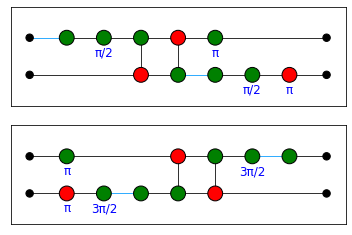

In [9]:
#qasm = qc.decompose().qasm()
pyzx.draw_many(circ_list, whichpyzx)

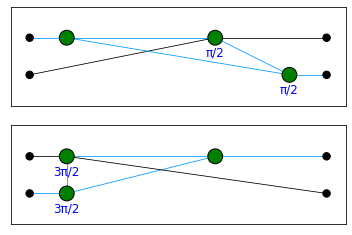

In [10]:
graph_list = [circ_list[w].to_graph() for w in whichpyzx]
[pyzx.full_reduce(g) for g in graph_list]
pyzx.draw_many(graph_list, range(len(whichpyzx)))

In [11]:
pyzx_circ_list = [pyzx.extract.streaming_extract(g) for g in graph_list]

for i in range(len(pyzx_circ_list)):
    prev = pyzx_circ_list[i]
    next = pyzx.extract.streaming_extract(graph_list[i])
    while prev.gates != next.gates:
        for j in range(len(next.gates))[::-1]:
            pyzx_circ_list[i].add_gate_to_front(next.gates[j])
        prev = next
        next = pyzx.extract.streaming_extract(graph_list[i])

pyzx_circ_list = [pyzx.optimize.basic_optimization(new_c.to_basic_gates()) for new_c in pyzx_circ_list]

pyzx_qasm = [new_c.to_basic_gates().to_qasm() for new_c in pyzx_circ_list]

passedAll = True
for i in range(len(pyzx_circ_list)):
    try:
        assert(pyzx.compare_tensors(pyzx_circ_list[i], circ_list[whichpyzx[i]]))
    except AssertionError:
        print(i)
        print(circ_list[whichpyzx[i]].__dict__)
        print(pyzx_circ_list[i].__dict__)
        passedAll = False
assert(passedAll)

0
{'qubits': 2, 'gates': [HAD(0), S(0), CNOT(0,1), CNOT(1,0), HAD(1), S(1), Z(0), NOT(1)], 'name': ''}
{'qubits': 2, 'gates': [S(1), CNOT(0,1), HAD(1)], 'name': ''}
1
{'qubits': 2, 'gates': [NOT(1), Z(0), S*(1), HAD(1), CNOT(1,0), CNOT(0,1), S*(0), HAD(0)], 'name': ''}
{'qubits': 2, 'gates': [CZ(0,1), HAD(0), S*(0)], 'name': ''}


AssertionError: 

In [ ]:
pyzx_qasm = ["\n".join(['' if line.startswith("qreg") else line for line in circ.splitlines()[2:]]) for circ in pyzx_qasm]

for new_qasm in pyzx_qasm:
    [print(line) for line in new_qasm.splitlines()]
    print()

In [ ]:
#now we need to map registers and glue all the pieces back together
for i in range(len(pyzx_qasm)):
    circ_list[whichpyzx[i]] = pyzx_qasm[i]
#print(circ_list)
## join the
qasm_string = 'OPENQASM 2.0;\ninclude "qelib1.inc";\n'+"\n".join(circ_list)
qasm_string = qasm_string.replace('q[', 'qr[')
print(qasm_string)

In [ ]:
# pqsl = [line + "\n" for line in pyzx_qasm] #took out .splitlines()
# qsl = [line + "\n" for line in qasm.splitlines()]
# # print(pqsl)
# # print(qsl)
# new_qasm = '\n'.join(qsl[0:4]) + ''.join(pqsl[3:]) + ''.join(qsl[-2:])
# new_qasm = new_qasm.replace('q[', 'qr[')
# print(new_qasm)

In [ ]:
new_qc = qc.from_qasm_str(qasm_string)
print(new_qc)

In [ ]:
print(qc)

In [ ]:
import qiskit
from qiskit.providers.basicaer import QasmSimulatorPy
c1 = qiskit.execute(qc, QasmSimulatorPy()).result().get_counts()
c2 = qiskit.execute(new_qc, QasmSimulatorPy()).result().get_counts()

In [ ]:
c1

In [ ]:
c2

In [ ]:
assert(c1 == c2)

In [ ]:
qc.depth()

In [ ]:
qc.size()

In [ ]:
new_qc.depth()

In [ ]:
new_qc.size()

In [ ]:
new_new_qc = qiskit.transpile(qc, basis_gates=['u3', 'cx'], optimization_level=2)

In [ ]:
print(new_new_qc)

In [ ]:
new_new_qc.depth()

In [ ]:
new_new_qc.size()

In [ ]:
doubly_qc = qiskit.transpile(new_qc, basis_gates=['u3', 'cx'], optimization_level=2)
print(doubly_qc)

In [ ]:
doubly_qc.depth()

In [ ]:
doubly_qc.size()

In [ ]:
c3 = qiskit.execute(new_new_qc, QasmSimulatorPy()).result().get_counts()
c4 = qiskit.execute(doubly_qc, QasmSimulatorPy()).result().get_counts()
c3

In [ ]:
c4